In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set_style('darkgrid')

# Tensorflow Libraries
from keras_preprocessing.image import ImageDataGenerator

# System libraries
from pathlib import Path

# Metrics
from sklearn.metrics import classification_report

## Load Test Data

In [2]:
test_data = '../test/'

def load_data(path):
    dir = Path(path)
    hostile_data = list(dir.glob(r'hostile_images/*.jpg'))
    hostile_data = pd.Series(hostile_data, name='filepath').astype(str)
    hostile_label = pd.Series(['hostile']*len(hostile_data), name='label')
    hostile_df = pd.concat([hostile_data, hostile_label], axis=1)

    non_hostile_data = list(dir.glob(r'non_hostile_images/*.jpg'))
    non_hostile_data = pd.Series(non_hostile_data, name='filepath').astype(str)
    non_hostile_label = pd.Series(['non_hostile']*len(non_hostile_data), name='label')
    non_hostile_df = pd.concat([non_hostile_data, non_hostile_label], axis=1)

    combined_df = pd.concat([hostile_df, non_hostile_df], ignore_index=True)
    return combined_df

test_df = load_data(test_data)
print(test_df.shape)

(682, 2)


In [3]:
image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 682 validated image filenames belonging to 2 classes.


## Normal InceptionV3 model

In [4]:
# load the model from disk
loaded_model = tf.keras.models.load_model('../saved_models/model_inceptionv3.h5')

# Evaluate model
results = loaded_model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# Predict the label of the test_images
pred = loaded_model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = {0: 'hostile', 1: 'non_hostile'}
pred = [labels[k] for k in pred]

    Test Loss: 0.00551
Test Accuracy: 99.85%
22/22 [==============================] - 66s 3s/step


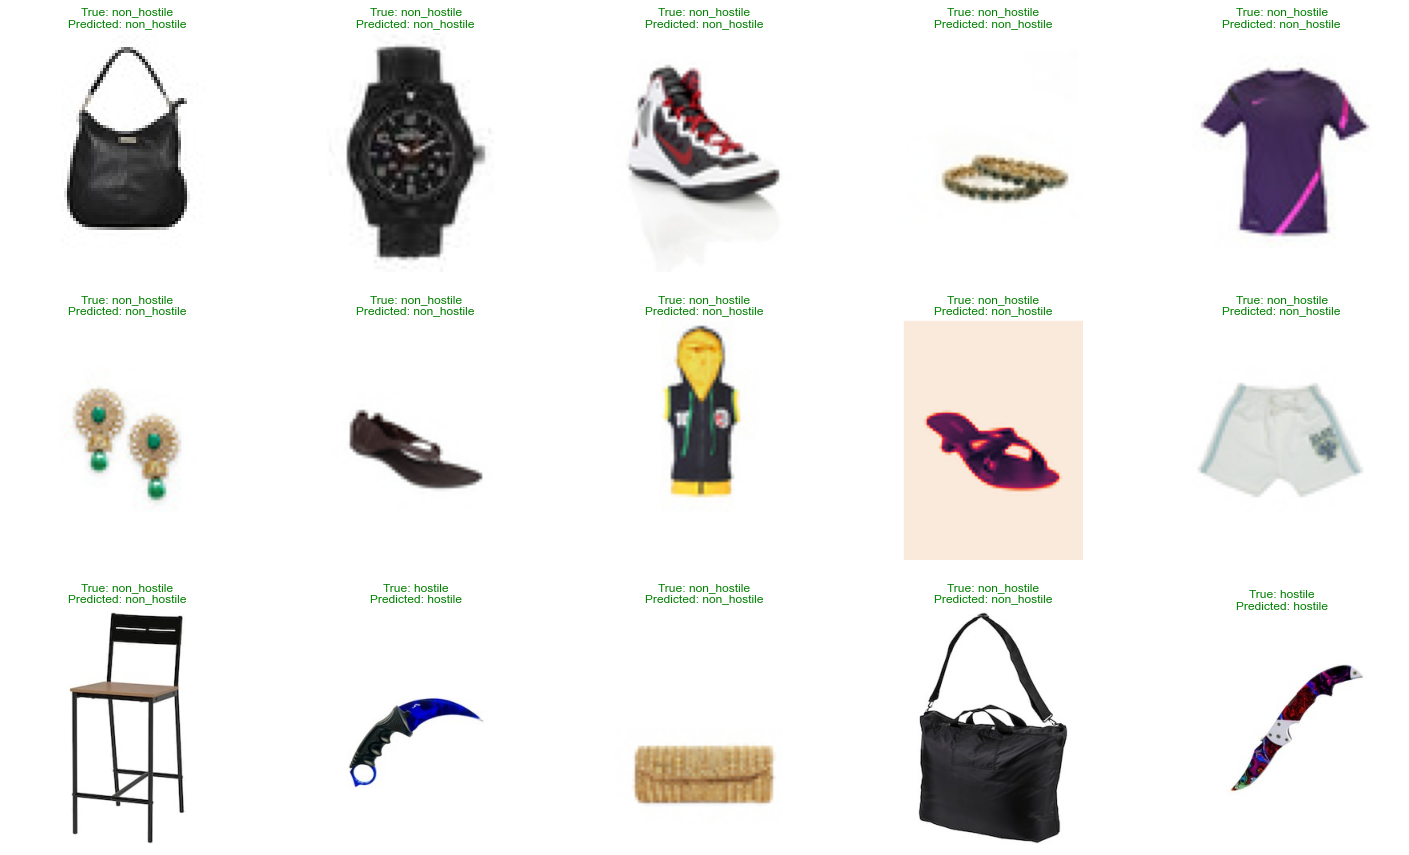

<Figure size 432x288 with 0 Axes>

In [6]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#### Results

In [7]:
y_test = list(test_df.label)
report = classification_report(y_test, pred, output_dict=True, digits=4)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
hostile,1.000000,0.982143,0.990991,56.000000
non_hostile,0.998405,1.000000,0.999202,626.000000
accuracy,0.998534,0.998534,0.998534,0.998534
macro avg,0.999203,0.991071,0.995096,682.000000
weighted avg,0.998536,0.998534,0.998528,682.000000


## InceptionV3 with Oversampling

In [11]:
# load the model from disk
loaded_model_oversample = tf.keras.models.load_model('../saved_models/model_inceptionv3_oversample.h5')

# Evaluate model
results_oversample = loaded_model_oversample.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results_oversample[0]))
print("Test Accuracy: {:.2f}%".format(results_oversample[1] * 100))

# Predict the label of the test_images
pred_oversample = loaded_model_oversample.predict(test_images)
pred_oversample = np.argmax(pred_oversample,axis=1)

# Map the label
pred_oversample = [labels[k] for k in pred_oversample]

    Test Loss: 0.00282
Test Accuracy: 99.71%
22/22 [==============================] - 31s 1s/step


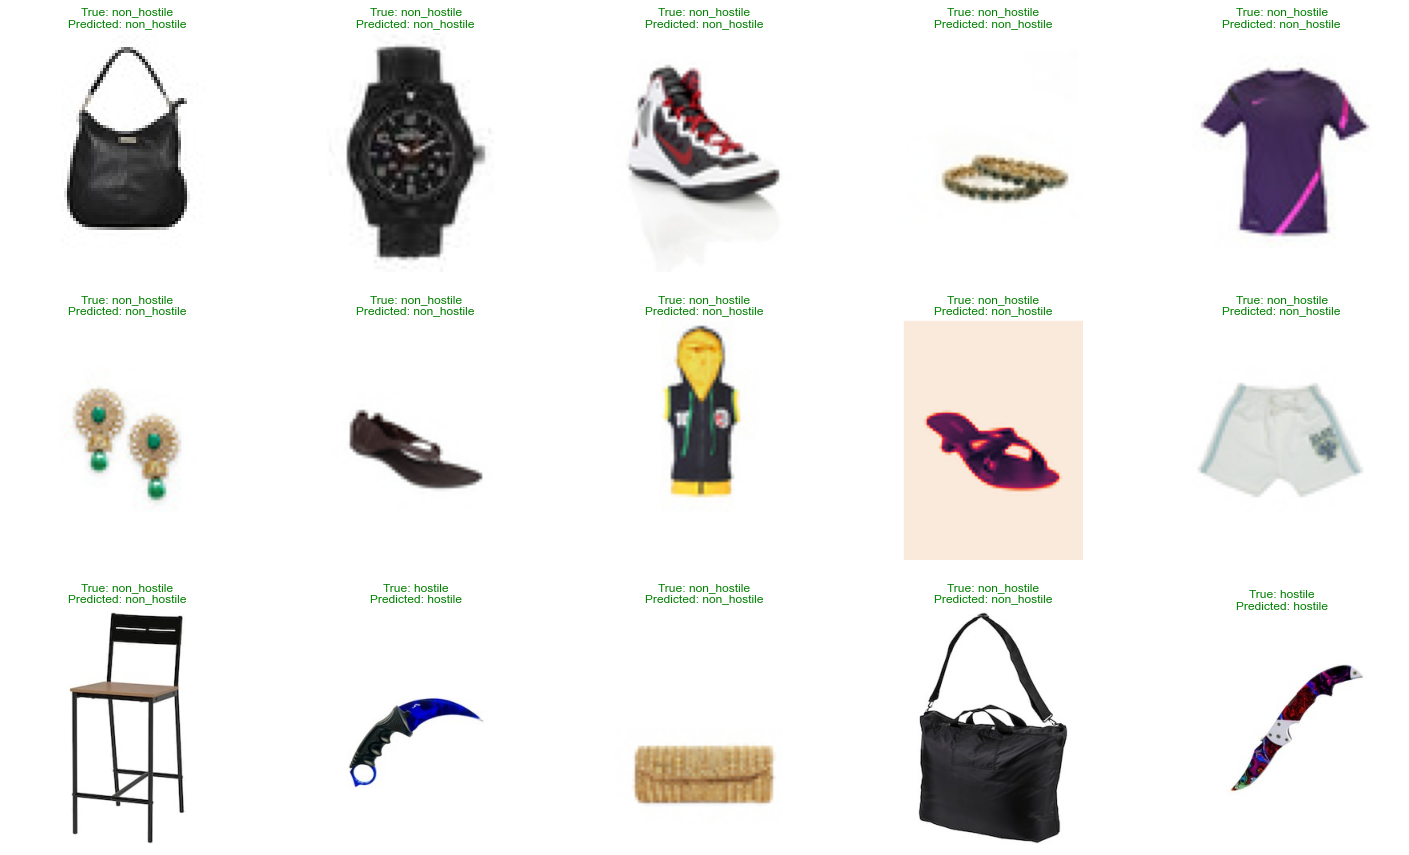

<Figure size 432x288 with 0 Axes>

In [12]:
# Display 25 random pictures from the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred_oversample[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred_oversample[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#### Results

In [13]:
y_test = list(test_df.label)
report_oversample = classification_report(y_test, pred_oversample, output_dict=True, digits=4)
df_oversample = pd.DataFrame(report_oversample).transpose()
df_oversample

,precision,recall,f1-score,support
hostile,0.982143,0.982143,0.982143,56.000000
non_hostile,0.998403,0.998403,0.998403,626.000000
accuracy,0.997067,0.997067,0.997067,0.997067
macro avg,0.990273,0.990273,0.990273,682.000000
weighted avg,0.997067,0.997067,0.997067,682.000000


## InceptionV3 with Undersampling

In [14]:
# load the model from disk
loaded_model_undersample = tf.keras.models.load_model('../saved_models/model_inceptionv3_undersample.h5')

# Evaluate model
results_undersample = loaded_model_undersample.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results_undersample[0]))
print("Test Accuracy: {:.2f}%".format(results_undersample[1] * 100))

# Predict the label of the test_images
pred_undersample = loaded_model_undersample.predict(test_images)
pred_undersample = np.argmax(pred_undersample,axis=1)

# Map the label
pred_undersample = [labels[k] for k in pred_undersample]

    Test Loss: 0.02794
Test Accuracy: 99.12%
11/22 [==============>...............] - ETA: 15s

In [ ]:
# Display 25 random pictures from the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred_undersample[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred_undersample[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#### Results

In [ ]:
y_test = list(test_df.label)
report_undersample = classification_report(y_test, pred_undersample, output_dict=True, digits=4)
df_undersample = pd.DataFrame(report_undersample).transpose()
df_undersample